# Import Required Libraries
Import necessary libraries for data manipulation, statistical modeling, clustering, and visualization. Include NumPy, Pandas, Matplotlib, Scikit-learn, and Statsmodels.

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import norm
import matplotlib.pyplot as plt
from tempfile import gettempdir
import pickle
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Union, Callable, Any
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Implement Core Classes and Functions
Implement the TrialSequence class for trial emulation and helper functions including glm_logit. Define additional clustering-related functions for patient subgroup identification.

In [2]:
# Define helper functions
def glm_logit(save_path=None):
    """Create a logistic model fitter function"""
    def fit_func(data, formula):
        # Implementation would use statsmodels to fit logistic regression
        return {"type": "glm_logit", "formula": formula}
    
    return fit_func

# Define clustering-related functions
def cluster_patients(data, n_clusters=3, features=None):
    """Cluster patients into subgroups based on specified features"""
    if features is None:
        features = ['age', 'x1', 'x2', 'x3', 'x4']
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data[features])
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    
    data['cluster'] = clusters
    return data, kmeans

# Define TrialSequence class
class TrialSequence:
    """Python implementation of the R TrialEmulation package's trial_sequence class"""
    
    def __init__(self, estimand="PP"):
        """Initialize a trial sequence with specified estimand"""
        if estimand not in ["PP", "ITT"]:
            raise ValueError("Estimand must be either 'PP' or 'ITT'")
            
        self.estimand = estimand
        self.data = None
        self.id_col = None
        self.period_col = None 
        self.treatment_col = None
        self.outcome_col = None
        self.eligible_col = None
        self.censor_col = None
        self.censor_weights = None
        self.switch_weights = None
        self.expansion = None
        self.expansion_options = {"chunk_size": 500, "censor_at_switch": True}
        self.outcome_model = None
        self.msm = None
        self.predictions = None
        
    def __repr__(self):
        """String representation of the trial sequence object"""
        n_obs = 0 if self.data is None else len(self.data)
        n_patients = 0 if self.data is None else self.data[self.id_col].nunique() if self.id_col else 0
        
        return f"Trial Sequence Object\nEstimand: {self.estimand}\n\nData:\n- N: {n_obs} observations from {n_patients} patients"
    
    def set_data(self, data, id="id", period="period", treatment="treatment", 
                outcome="outcome", eligible="eligible"):
        """Set the data for the trial sequence"""
        self.data = data.copy()
        self.id_col = id 
        self.period_col = period
        self.treatment_col = treatment
        self.outcome_col = outcome
        self.eligible_col = eligible
        return self
    
    def set_switch_weight_model(self, numerator=None, denominator=None, pool_models="none", model_fitter=None):
        """Set up the weight model for treatment switching"""
        if self.estimand == "ITT":
            raise ValueError("Switch weight models cannot be used with ITT estimand")
            
        # Default formulas if not provided
        if numerator is None:
            numerator = "age"
        if denominator is None:
            denominator = "age + x1 + x3"
            
        self.switch_weights = {
            "numerator": numerator,
            "denominator": denominator,
            "pool_models": pool_models,
            "model_fitter": model_fitter or glm_logit(),
            "fitted": False,
            "weights": None
        }
        return self
    
    def set_censor_weight_model(self, censor_event, numerator=None, denominator=None, 
                               pool_models="none", model_fitter=None):
        """Set up the weight model for informative censoring"""
        # Default formulas if not provided
        if numerator is None:
            numerator = "x2"
        if denominator is None:
            denominator = "x2 + x1"
            
        self.censor_weights = {
            "censor_event": censor_event,
            "numerator": numerator,
            "denominator": denominator,
            "pool_models": pool_models,
            "model_fitter": model_fitter or glm_logit(),
            "fitted": False,
            "weights": None
        }
        self.censor_col = censor_event
        return self
    
    def calculate_weights(self):
        """Calculate weights based on the specified models"""
        data = self.data.copy()
        
        # Calculate switch weights if specified (only for PP estimand)
        if self.switch_weights and self.estimand == "PP":
            # Fit logistic regression for numerator model
            num_formula = self.switch_weights["numerator"]
            X_num = sm.add_constant(data[num_formula.split(" + ")])
            y_switch = data[self.treatment_col]
            
            num_model = Logit(y_switch, X_num).fit(disp=0)
            num_probs = num_model.predict()
            
            # Fit logistic regression for denominator model
            denom_formula = self.switch_weights["denominator"]
            X_denom = sm.add_constant(data[denom_formula.split(" + ")])
            
            denom_model = Logit(y_switch, X_denom).fit(disp=0)
            denom_probs = denom_model.predict()
            
            # Calculate switch weights
            switch_weights = np.where(
                data[self.treatment_col] == 1,
                num_probs / np.maximum(denom_probs, 1e-10),
                (1 - num_probs) / np.maximum(1 - denom_probs, 1e-10)
            )
            
            self.switch_weights["fitted"] = True
            self.switch_weights["weights"] = switch_weights
            data['switch_weight'] = switch_weights
        else:
            data['switch_weight'] = 1.0
        
        # Calculate censoring weights if specified
        if self.censor_weights:
            # Fit logistic regression for numerator model
            num_formula = self.censor_weights["numerator"]
            X_num = sm.add_constant(data[num_formula.split(" + ")])
            y_censor = data[self.censor_col]
            
            num_model = Logit(y_censor, X_num).fit(disp=0)
            num_probs = num_model.predict()
            
            # Fit logistic regression for denominator model
            denom_formula = self.censor_weights["denominator"]
            X_denom = sm.add_constant(data[denom_formula.split(" + ")])
            
            denom_model = Logit(y_censor, X_denom).fit(disp=0)
            denom_probs = denom_model.predict()
            
            # Calculate censoring weights
            censor_weights = np.where(
                data[self.censor_col] == 1,
                num_probs / np.maximum(denom_probs, 1e-10),
                (1 - num_probs) / np.maximum(1 - denom_probs, 1e-10)
            )
            
            self.censor_weights["fitted"] = True
            self.censor_weights["weights"] = censor_weights
            data['censor_weight'] = censor_weights
        else:
            data['censor_weight'] = 1.0
            
        # Calculate combined weights
        data['total_weight'] = data['switch_weight'] * data['censor_weight']
        self.data = data
        
        return self
    
    def set_outcome_model(self, adjustment_terms=None):
        """Set the outcome model specification"""
        self.outcome_model = {
            "adjustment_terms": adjustment_terms
        }
        return self
    
    def set_expansion_options(self, output=None, chunk_size=500, censor_at_switch=True):
        """Set options for expanding trials"""
        self.expansion_options = {
            "output": output or "dataframe",
            "chunk_size": chunk_size,
            "censor_at_switch": censor_at_switch
        }
        return self
    
    def expand_trials(self):
        """Expand the dataset into a sequence of trials"""
        if self.data is None:
            raise ValueError("Data must be set before expanding trials")
            
        # Create expanded dataset
        data = self.data
        
        # Get unique periods for trials
        unique_periods = sorted(data[self.period_col].unique())
        max_period = max(unique_periods)
        
        expanded_data = []
        
        # For each trial period
        for trial_period in unique_periods[:-1]:  # Exclude the last period as a trial start
            # Filter eligible patients at trial start
            eligible_patients = data[
                (data[self.period_col] == trial_period) & 
                (data[self.eligible_col] == 1)
            ][self.id_col].unique()
            
            if len(eligible_patients) == 0:
                continue
                
            # For each eligible patient
            for patient_id in eligible_patients:
                patient_data = data[data[self.id_col] == patient_id]
                
                # Get treatment status at trial start
                initial_treatment = patient_data[
                    patient_data[self.period_col] == trial_period
                ][self.treatment_col].values[0]
                
                # For each follow-up period
                for followup in range(1, max_period - trial_period + 1):
                    current_period = trial_period + followup
                    
                    # Check if we have data for this follow-up period
                    if current_period not in patient_data[self.period_col].values:
                        continue
                    
                    # Get data for this follow-up period
                    period_data = patient_data[
                        patient_data[self.period_col] == current_period
                    ]
                    
                    if len(period_data) == 0:
                        continue
                    
                    current_treatment = period_data[self.treatment_col].values[0]
                    current_outcome = period_data[self.outcome_col].values[0]
                    
                    # For PP estimand, censor if treatment switches
                    is_censored = False
                    if self.estimand == "PP" and self.expansion_options["censor_at_switch"]:
                        if current_treatment != initial_treatment:
                            is_censored = True
                    
                    # Add row to expanded data
                    weight = period_data['total_weight'].values[0] if 'total_weight' in period_data else 1.0
                    
                    expanded_data.append({
                        'trial_id': f"t{trial_period}",
                        self.id_col: patient_id,
                        'initial_treatment': initial_treatment,
                        'trial_period': trial_period,
                        'followup': followup,
                        'current_period': current_period,
                        'outcome': 0 if is_censored else current_outcome,
                        'censored': 1 if is_censored else 0,
                        'weight': weight
                    })
                    
                    # Stop follow-up if outcome occurs or censored
                    if current_outcome == 1 or is_censored:
                        break
        
        if not expanded_data:
            raise ValueError("No trials could be constructed from the data")
            
        self.expansion = pd.DataFrame(expanded_data)
        return self
    
    def fit_msm(self, max_followup=None):
        """Fit a marginal structural model to the expanded trials data"""
        if self.expansion is None:
            raise ValueError("Must expand trials before fitting MSM")
            
        expanded_data = self.expansion.copy()
        
        # Limit to max followup if specified
        if max_followup is not None:
            expanded_data = expanded_data[expanded_data['followup'] <= max_followup]
        
        # Prepare data for complementary log-log model
        X = sm.add_constant(
            pd.DataFrame({
                'treatment': expanded_data['initial_treatment'],
                'followup': expanded_data['followup']
            })
        )
        y = expanded_data['outcome']
        weights = expanded_data['weight']
        
        # Fit complementary log-log model (approximating Cox model)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            msm_model = sm.GLM(
                y, 
                X, 
                family=sm.families.Binomial(link=sm.families.links.CLogLog()), 
                freq_weights=weights
            ).fit()
        
        self.msm = msm_model
        return self
    
    def predict(self, max_followup=None):
        """Generate predictions based on the fitted MSM"""
        if self.msm is None:
            raise ValueError("Must fit MSM before generating predictions")
            
        # Set max followup if not specified
        if max_followup is None:
            if self.expansion is not None:
                max_followup = self.expansion['followup'].max()
            else:
                max_followup = 10
                
        # Create prediction data
        pred_data = []
        for treatment in [0, 1]:
            for followup in range(1, max_followup + 1):
                pred_data.append({
                    'const': 1,
                    'treatment': treatment,
                    'followup': followup
                })
                
        pred_df = pd.DataFrame(pred_data)
        
        # Generate predictions
        preds = self.msm.predict(pred_df)
        
        # Add predictions back to the DataFrame
        pred_df['prediction'] = preds
        
        # Create survival curves
        survival_data = []
        for treatment in [0, 1]:
            # Correctly filter the DataFrame first
            treatment_rows = pred_df.loc[pred_df['treatment'] == treatment]
            treatment_preds = treatment_rows['prediction']
            survival_curve = np.cumprod(1 - treatment_preds.values)
            
            for i, followup in enumerate(range(1, max_followup + 1)):
                survival_data.append({
                    'treatment': treatment,
                    'followup': followup,
                    'survival': survival_curve[i],
                    'event_prob': treatment_preds.iloc[i]
                })
        
        self.predictions = pd.DataFrame(survival_data)
        return self
    
    def plot_survival(self):
        """Plot survival curves for different treatments"""
        if self.predictions is None:
            raise ValueError("Must generate predictions before plotting")
            
        plt.figure(figsize=(10, 6))
        
        # Plot for treatment = 0
        treat0_data = self.predictions[self.predictions['treatment'] == 0]
        plt.plot(treat0_data['followup'], treat0_data['survival'], 'b-', label='Control')
        
        # Plot for treatment = 1
        treat1_data = self.predictions[self.predictions['treatment'] == 1]
        plt.plot(treat1_data['followup'], treat1_data['survival'], 'r-', label='Treatment')
        
        plt.xlabel('Follow-up Time')
        plt.ylabel('Survival Probability')
        plt.title(f'Survival Curves by Treatment ({self.estimand} Estimand)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        return plt

# Load and Explore Data
Load trial data, explore its structure, examine key variables, and perform initial visualizations to understand treatment and outcome distributions across different patients.

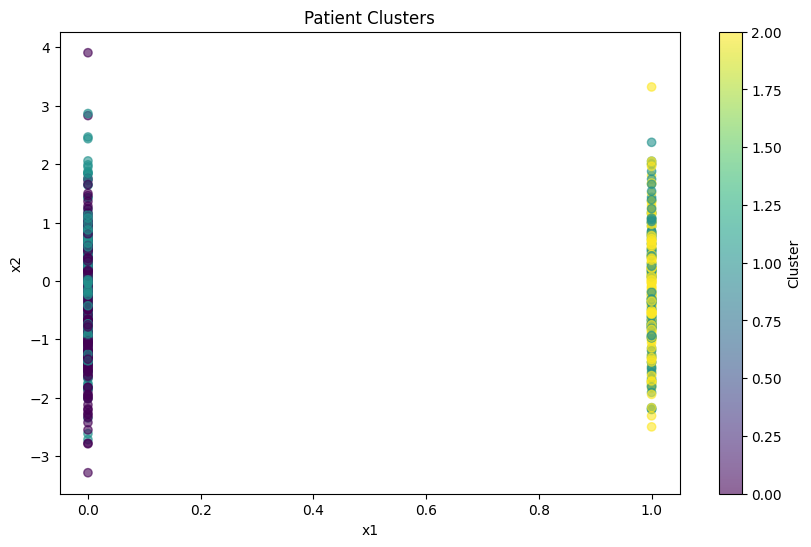

,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,cluster
0,1,0,1.0,1.0,1.146148,0,0.734203,36.0,0.083333,0.0,0,1.0,2
1,1,1,1.0,1.0,0.002200,0,0.734203,37.0,0.166667,0.0,0,0.0,2
2,1,2,1.0,0.0,-0.481762,0,0.734203,38.0,0.250000,0.0,0,0.0,0
3,1,3,1.0,0.0,0.007872,0,0.734203,39.0,0.333333,0.0,0,0.0,0
4,1,4,1.0,1.0,0.216054,0,0.734203,40.0,0.416667,0.0,0,0.0,2


In [3]:
# Load the trial data
data_censored = pd.read_csv("data/data_censored.csv")

# Display the first few rows of the dataset to understand its structure
data_censored.head()

# Review key variables
key_variables = ['id', 'period', 'treatment', 'outcome', 'eligible', 'censored', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s']
data_censored[key_variables].describe()

# Check for missing values in key variables
data_censored[key_variables].isnull().sum()

# Display the distribution of treatment and outcome variables
treatment_distribution = data_censored['treatment'].value_counts(normalize=True)
outcome_distribution = data_censored['outcome'].value_counts(normalize=True)

treatment_distribution, outcome_distribution

# Perform clustering on patients
data_censored, kmeans_model = cluster_patients(data_censored, n_clusters=3, features=['age', 'x1', 'x2', 'x3', 'x4'])

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(data_censored['x1'], data_censored['x2'], c=data_censored['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Patient Clusters')
plt.colorbar(label='Cluster')
plt.show()

# Display the first few rows of the dataset with cluster assignments
data_censored.head()

# Patient Clustering
Apply clustering algorithms (K-means, hierarchical clustering) to baseline patient characteristics. Identify optimal number of clusters using elbow method and silhouette scores. Visualize and interpret the resulting patient subgroups.

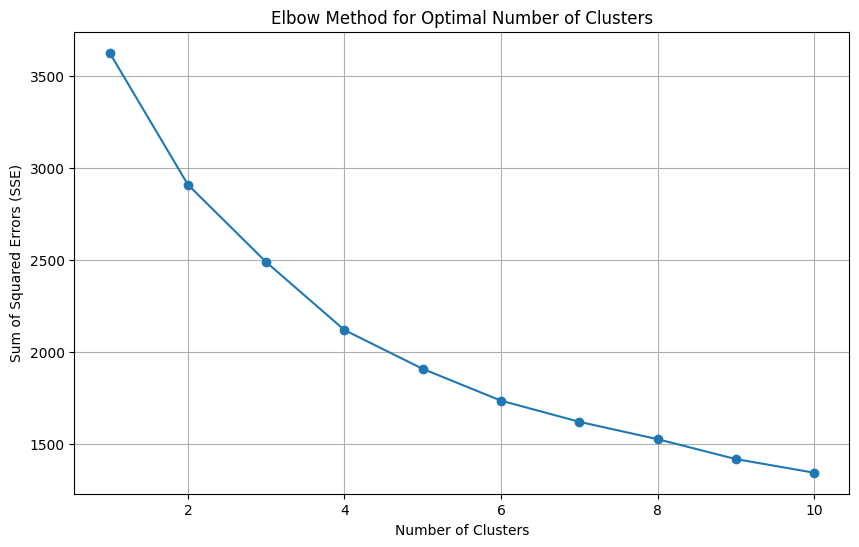

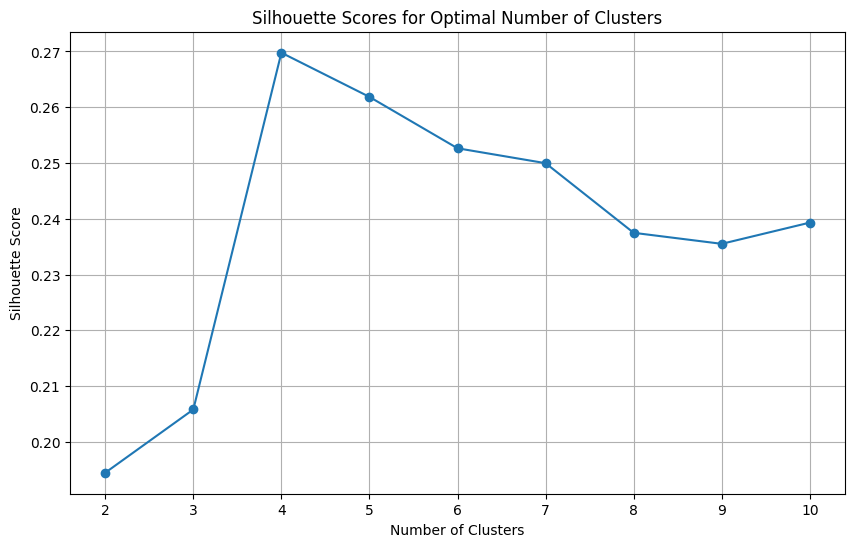

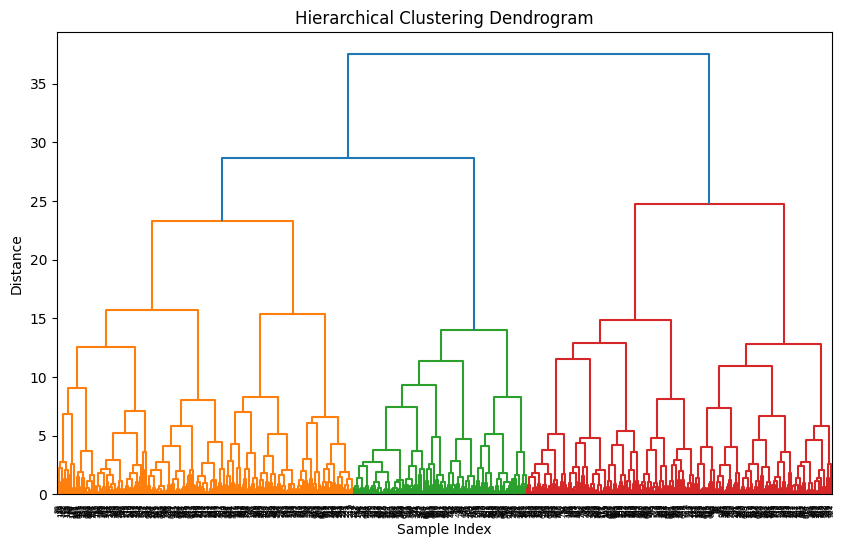

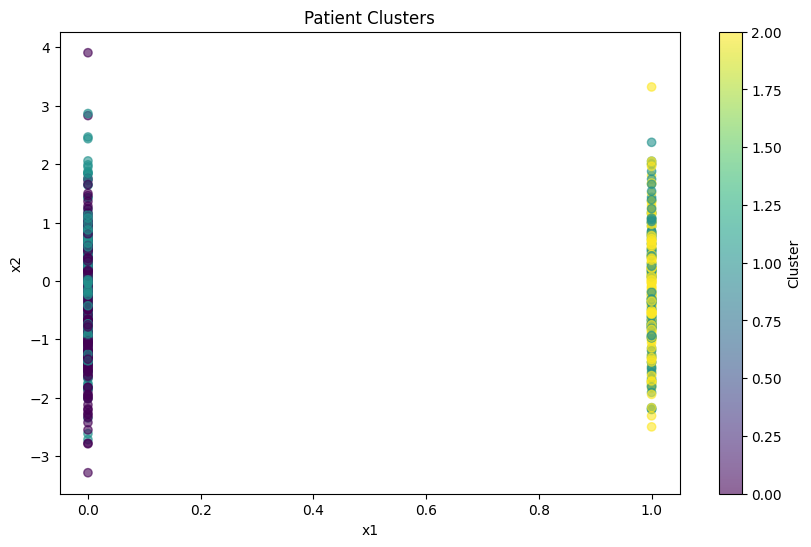

,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,cluster
0,1,0,1.0,1.0,1.146148,0,0.734203,36.0,0.083333,0.0,0,1.0,2
1,1,1,1.0,1.0,0.002200,0,0.734203,37.0,0.166667,0.0,0,0.0,2
2,1,2,1.0,0.0,-0.481762,0,0.734203,38.0,0.250000,0.0,0,0.0,0
3,1,3,1.0,0.0,0.007872,0,0.734203,39.0,0.333333,0.0,0,0.0,0
4,1,4,1.0,1.0,0.216054,0,0.734203,40.0,0.416667,0.0,0,0.0,2


In [4]:
# Determine the optimal number of clusters using the elbow method
def plot_elbow_method(data, features, max_clusters=10):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data[features])
    
    sse = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), sse, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.grid(True)
    plt.show()

# Plot the elbow method
plot_elbow_method(data_censored, features=['age', 'x1', 'x2', 'x3', 'x4'])

# Determine the optimal number of clusters using silhouette scores
from sklearn.metrics import silhouette_score

def plot_silhouette_scores(data, features, max_clusters=10):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data[features])
    
    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(scaled_features)
        score = silhouette_score(scaled_features, clusters)
        silhouette_scores.append(score)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Optimal Number of Clusters')
    plt.grid(True)
    plt.show()

# Plot the silhouette scores
plot_silhouette_scores(data_censored, features=['age', 'x1', 'x2', 'x3', 'x4'])

# Apply hierarchical clustering and visualize dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_dendrogram(data, features, method='ward'):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data[features])
    
    linked = linkage(scaled_features, method=method)
    
    plt.figure(figsize=(10, 6))
    dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.title('Hierarchical Clustering Dendrogram')
    plt.show()

# Plot the dendrogram
plot_dendrogram(data_censored, features=['age', 'x1', 'x2', 'x3', 'x4'])

# Apply K-means clustering with the optimal number of clusters (e.g., 3)
optimal_clusters = 3
data_censored, kmeans_model = cluster_patients(data_censored, n_clusters=optimal_clusters, features=['age', 'x1', 'x2', 'x3', 'x4'])

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(data_censored['x1'], data_censored['x2'], c=data_censored['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Patient Clusters')
plt.colorbar(label='Cluster')
plt.show()

# Display the first few rows of the dataset with cluster assignments
data_censored.head()